In [17]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.algorithms.moo.age2 import AGEMOEA2

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem, MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory, get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward, MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L

In [18]:
import itertools
list(itertools.permutations([0,1,2]))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

{'Main_knee_2': (-0.30000000000000004, -0.1)}
[-0.3]


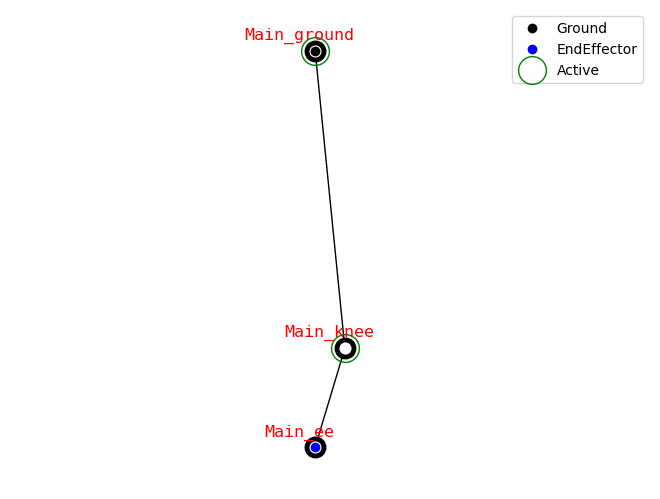

In [19]:
gm = GraphManager2L()
gm.reset()
gm.build_main(0.4, fully_actuated=True)
gm.set_mutation_ranges()
print(gm.mutation_ranges)
center = gm.generate_central_from_mutation_range()
center[0] = -0.3
print(center)
graph = gm.get_graph(center)
draw_joint_point(graph)

In [20]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [21]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_workspace_trajectory([-0.15, -0.35], 0.14, 0.3, 30, 60)))
# ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.1, -0.31], step_height=0.05, step_width=0.2, n_points=50))

ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14, -0.34], step_height=0.12, step_width=0.28, n_points=200)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14 + 0.015, -0.34], step_height=0.10, step_width=-2*(-0.14 + 0.015), n_points=200)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.14 + 0.025 , -0.34], step_height=0.08, step_width=-2*(-0.14 + 0.025), n_points=200)))

central_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, 0, 200)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, -0.12, 200)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.34, 0.12, 0.12, 200)))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria, alg_name="Open_Loop")

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
min_velocity = MinManipulabilityReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

min_force = MinForceReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(
    error_calculator=error_calculator, points=[workspace_trajectory])


soft_constrain = PositioningConstrain(
    error_calculator=error_calculator, points=[ground_symmetric_step1, ground_symmetric_step2, ground_symmetric_step3, central_vertical, left_vertical, right_vertical])

#
# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)

reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

In [22]:
center

[-0.3]

In [23]:
center[0] = -0.29900169
graph = gm.get_graph(center)
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)
# position constrain
reward_manager.precalculated_trajectories = None
constrain_error, results = soft_constrain.calculate_constrain_error(crag, fixed_robot, free_robot)

constrain_error

0.0

In [24]:
x = 0.29900169
radius1 = ((0.4-x)**2+0.03**2)**0.5+(0.03**2+x**2)**0.5 
radius2 = (0.03**2+0.3**2)**0.5  - ((0.4-0.3)**2+0.03**2)**0.5

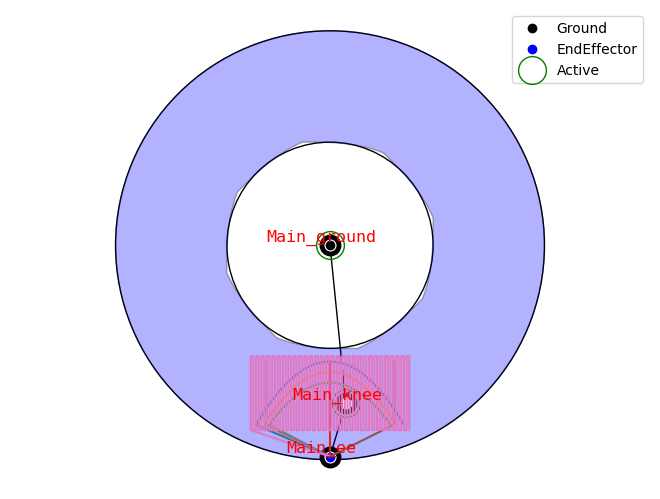

In [25]:
from matplotlib.patches import Circle, PathPatch
from matplotlib.path import Path
draw_joint_point(graph)
# Parameters for the circles
center = (0, 0)
x = 0.29900169
radius1 = ((0.4-x)**2+0.03**2)**0.5+(0.03**2+x**2)**0.5 
radius2 = (0.03**2+x**2)**0.5  - ((0.4-x)**2+0.03**2)**0.5

# Create a figure and axis
ax = plt.gca()

# Define the outer and inner circles
outer_circle = Circle(center, radius1, edgecolor='black', facecolor='none')
inner_circle = Circle(center, radius2, edgecolor='black', facecolor='none')

# Add circles to the plot
ax.add_patch(outer_circle)
ax.add_patch(inner_circle)

# Create the paths for the circles
outer_path = Path.circle(center=center, radius=radius1)
inner_path = Path.circle(center=center, radius=radius2)

# Create the path patch for the area between the circles
vertices = np.concatenate([outer_path.vertices, inner_path.vertices[::-1]])
codes = np.concatenate([outer_path.codes, inner_path.codes])
path = Path(vertices, codes)
patch = PathPatch(path, facecolor='blue', alpha=0.3)

# Add the path patch to the plot
ax.add_patch(patch)
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

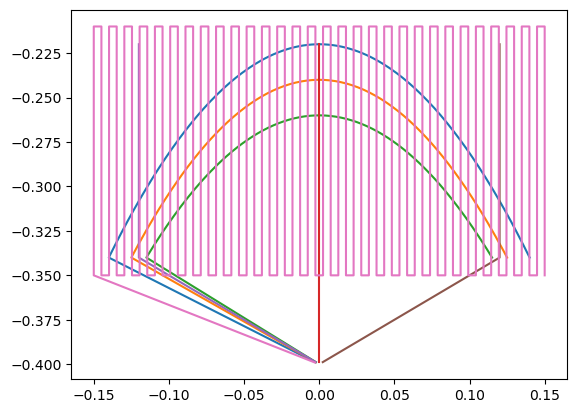

In [26]:


for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [27]:
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

In [33]:


population_size = 32
n_generations = 10

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    False, **{
        "seed": 3,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

     1 |       32 |     18 |  0.0608132488 |         ideal
     2 |       64 |     32 |  0.0182942069 |         ideal
     3 |       96 |     32 |  0.0150909285 |             f
     4 |      128 |     32 |  0.0196381716 |         ideal
     5 |      160 |     32 |  0.0048681179 |             f
     6 |      192 |     32 |  0.0173350715 |         ideal


KeyboardInterrupt: 

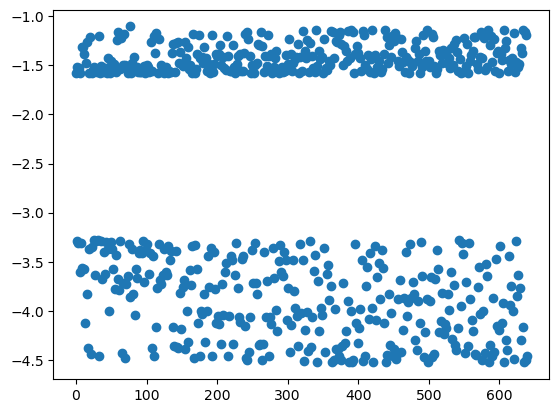

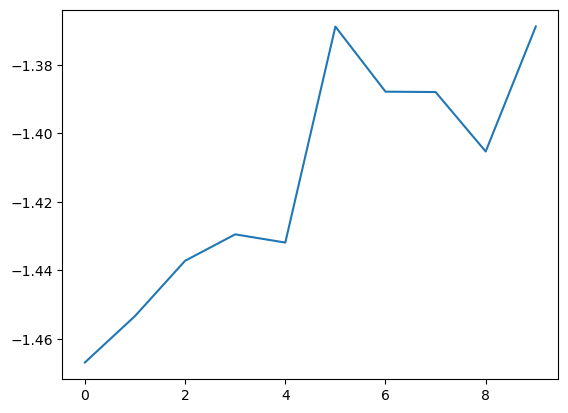

In [29]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)), flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)), history_mean[:, 0])
plt.show()


In [30]:
flatten_history

array([-1.57546846, -3.29321327, -1.51520034, -3.30460291, -1.52711709,
       -3.60510324, -1.57877707, -3.3127828 , -1.31528711, -3.56694598,
       -1.30972445, -3.57467991, -1.38845666, -4.11886183, -1.47372949,
       -3.82462287, -1.26077326, -4.38309659, -1.57491811, -3.36928776,
       -1.21443152, -4.43963493, -1.57684342, -3.35372739, -1.5480907 ,
       -3.28279166, -1.52057783, -3.63280937, -1.53445808, -3.29003707,
       -1.56781427, -3.28244561, -1.20060074, -4.45614867, -1.57429639,
       -3.29035786, -1.50977532, -3.67790133, -1.57048909, -3.39821135,
       -1.52324625, -3.62154847, -1.52479986, -3.29678599, -1.57484818,
       -3.36980086, -1.4268438 , -3.99699456, -1.57629236, -3.29579156,
       -1.45678063, -3.36925122, -1.53463562, -3.57273127, -1.48507317,
       -3.77896969, -1.56420751, -3.43339855, -1.24052445, -3.67123579,
       -1.16014357, -3.78361864, -1.53665785, -3.28867956, -1.21895035,
       -4.43420391, -1.49916963, -3.72158202, -1.18270262, -4.47

In [31]:
history_mean

array([[-1.46690258, -3.59175214],
       [-1.45335537, -3.69256348],
       [-1.43722387, -3.87529277],
       [-1.42951372, -3.89091454],
       [-1.43191114, -3.8990477 ],
       [-1.36888371, -4.05356909],
       [-1.38787403, -3.99510238],
       [-1.38797977, -4.00631439],
       [-1.40532939, -3.97874849],
       [-1.36884873, -4.05430864]])

Scale f1: [-1.5789661010106404, -1.1406910022099812]
Scale f2: [-4.525680458400238, -3.319735745146842]


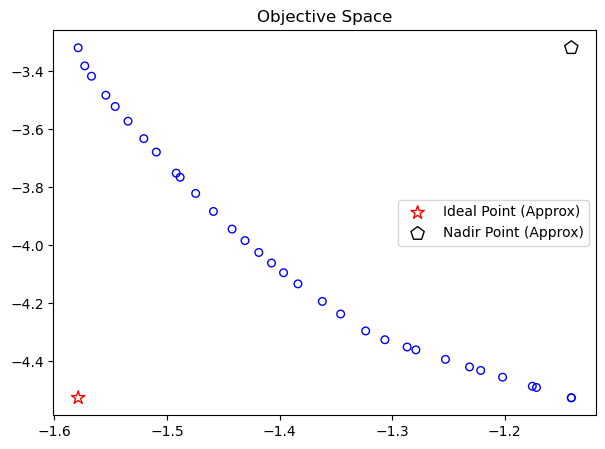

In [32]:
F = res.F
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none',
            edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none',
            edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()